# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
import warnings
from darts import TimeSeries
from darts.utils.model_selection import train_test_split
from darts.utils.statistics import plot_acf
import torch
from darts.models import CatBoostModel
from darts.metrics import mape,  mase
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from datetime import datetime, timedelta
import logging

warnings.simplefilter('ignore')
logging.disable(logging.CRITICAL)

%matplotlib inline

# for reproducibility
torch.manual_seed(1)
np.random.seed(1)

c:\Users\60126569\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsforecast\core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


# Необходимые функции

In [2]:
# Креды
def secreet_read(file):
    result = {}
    with open(file, 'r') as f:
        lines = f.readlines()
    for i, line in enumerate(lines, 1):
        key, value = map(str.strip, line.split(':'))
        result[key] = value
    return result

In [3]:
class SolutionConnector:
    def __init__(self, a
                 ) -> None:
        self.a =a
        user = self.a.get("user")
        password = self.a.get("password")
        host = self.a.get("host")
        dbname = self.a.get("dbname")
        port = self.a.get("port")
        self.engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}')

    def execute(self, query:str):
        try:
            select = pd.read_sql(query, self.engine)
        except Exception as e:
            print(f'Падение по причине {e}')
        return select

In [4]:
sql_query = f"""
select "date"
	, "№ Магазин исполнитель"
	, "Способ создания заказа"
	, "Способ получения заказа"
	, case 
		when customer_type = 'Физическое Лицо' then 'B2C'
		when customer_type = 'Юридическое Лицо' then 'B2B'
		when customer_type = 'PROFI' then 'Profi'     
		else 'B2C'
		end as "Тип клиента"
    , qnt_order    
	from (
		select order_create_dttm::date AS "date"
		    , executed_by_store_id::int AS "№ Магазин исполнитель"
		    , order_channel_name AS "Способ создания заказа"
		    , order_receive_type_name AS "Способ получения заказа"
		    , customer_type 
			, COUNT(DISTINCT order_id) AS qnt_order
		  FROM superset.order_superset
		  WHERE 1=1
		  and order_create_dt between date_trunc ('month', current_date - interval '17 month') and current_date- interval '1 day'
		  and executed_by_store_id::int not in (44,45,90,62,13,159,131,139,162,251,252,253,257,263,264) 
          --and order_status_name != 'Отменён'
		  --and executed_by_store_id::int = 2
		group by 1,2,3,4,5
		) h;
"""

In [5]:
secreet = secreet_read('креды.txt')

In [6]:
def dataset_info(frame):
    '''
    Создаёт описание датасета: шейп, дубликаты пропущенные зачения, типы данных в поле
    вход: датафрейм
    выход: описание
    '''
    print(f'rows/columns: {frame.shape}')
    print(f'duplicated rows: {frame.duplicated().sum()}')
    print('--------------------------')
    print('data types in columns:')
    print('---')
    print(frame.dtypes)
    print('--------------------------')
    print('NA values in columns:')
    print('---')
    print(frame.isna().sum())



In [7]:
def drop_dublicates(frame):
    '''
    Проверяет сет на наличие дупликатов при обнаружении удаляет их
    вход: датасет
    выход: датасет без дубликатов
    '''
    if frame.duplicated().sum() !=0:
        return frame.drop_duplicates(inplace=True)
    else:
        return print('дубликаты отсутствуют')

In [8]:
# вычисляет понедельники для дальнейшего определения календарной недели по ISO
def first_day_of_iso_week(date):
    day_of_week = date.weekday() # Вычисляем день недели (0 - понедельник, 6 - воскресенье)
    first_day_of_week = date - timedelta(days=day_of_week) # Вычитаем день недели из текущей даты, чтобы получить первый день календарной недели
    return first_day_of_week

In [9]:

def clean_nan_ts(ser):
    '''
    Проверяет каждую серию в массиве на наличие nan
    вход: двумерный массив 
    выход:  двумерный массив без серий содержащих nan значения 
    '''
    cleaned_series = [ts for ts in ser if not ts.pd_series().isnull().values.any()]
    return cleaned_series

In [10]:
def clean_nan_df(frame):
    if len(frame[frame.iloc[:,0].isna()==True]) > 0:
        frame.fillna(0, inplace=True)
    else:
        print('значения NaN отсутствуют')

# Данные

## Получение данных

In [11]:
solution_conn = SolutionConnector(secreet)
data_full = solution_conn.execute(sql_query)

## Подготовка данных

In [12]:
dataset_info(data_full)

rows/columns: (576984, 6)
duplicated rows: 0
--------------------------
data types in columns:
---
date                       object
№ Магазин исполнитель       int64
Способ создания заказа     object
Способ получения заказа    object
Тип клиента                object
qnt_order                   int64
dtype: object
--------------------------
NA values in columns:
---
date                       0
№ Магазин исполнитель      0
Способ создания заказа     0
Способ получения заказа    0
Тип клиента                0
qnt_order                  0
dtype: int64


In [13]:
data_full['first_day'] = data_full['date'].apply(first_day_of_iso_week) # находим начало недели
data_week = data_full.drop('date', axis=1) # удаляем ненужное больше поле даты

In [14]:
# агрегируем данные и приводим поле даты в нужный формат
data_agg_week = data_week.groupby(['first_day', '№ Магазин исполнитель', 'Способ создания заказа', 'Способ получения заказа', 'Тип клиента']).sum().reset_index()
data_agg_week['first_day'] = pd.to_datetime(data_agg_week['first_day'])

In [15]:
#смотрим инфо, проверяем на дубликаты, первично обрабатываем nan
dataset_info(data_agg_week)
drop_dublicates(data_agg_week)
clean_nan_df(data_agg_week)

rows/columns: (88152, 6)
duplicated rows: 0
--------------------------
data types in columns:
---
first_day                  datetime64[ns]
№ Магазин исполнитель               int64
Способ создания заказа             object
Способ получения заказа            object
Тип клиента                        object
qnt_order                           int64
dtype: object
--------------------------
NA values in columns:
---
first_day                  0
№ Магазин исполнитель      0
Способ создания заказа     0
Способ получения заказа    0
Тип клиента                0
qnt_order                  0
dtype: int64
дубликаты отсутствуют
значения NaN отсутствуют


## Временные ряды: преобразование и очистка

In [16]:
# преобразовываем датафрейм в двхумерный массив
df_time_series = TimeSeries.from_group_dataframe(data_agg_week
                                            , group_cols=['№ Магазин исполнитель', 'Способ создания заказа', 'Способ получения заказа', 'Тип клиента']
                                            , time_col = 'first_day'
                                            , value_cols= 'qnt_order'
                                            , fill_missing_dates=True
                                            , freq= 'W-MON'
                                            )

In [17]:
#Оставляем в массиве серии необходимой длинны (72 недели)
true_len_ser = [i for i in df_time_series if len(i) >= 72]

In [18]:
# чистим массив от серий с nan значениями и смотрим соотношение до и после
df_coreckt = clean_nan_ts(true_len_ser)

In [19]:
# сплитование DF

split_multi_df = train_test_split(df_coreckt, axis=1)
df_train = split_multi_df[0]
df_test = split_multi_df[1]

In [ ]:
# логирование данных перед подачей в модель
output_file = "C:/Users/60126569/Мои скрипты/all_data_2.parquet"
data_a.to_parquet(output_file)

# Обучение моделей

## Catboost

In [20]:
catboost_params = {
    'iterations': 3000,
    'depth': 3,
    'learning_rate': 0.02,
    'l2_leaf_reg': 4.5,
    'random_strength': 1.6,
    'bagging_temperature': 1.8,
    #'grow_policy': 'SymmetricTree',
    'verbose': 0,
    #'max_bin':255,  
}

model_catboost = CatBoostModel(lags=[-1, -5, -14, -26, -39, -51]
                               , lags_past_covariates=[-1, -5, -14, -26, -39, -51]
                               #, lags_future_covariates=[1, 5]
                               , use_static_covariates=False
                               , random_seed=700
                               , **catboost_params
                               )



In [21]:
model_catboost.fit(df_train
                   , past_covariates=df_coreckt
                   #, future_covariates=df_multi_scaled
                   )

CatBoostModel(lags=[-1, -5, -14, -26, -39, -51], lags_past_covariates=[-1, -5, -14, -26, -39, -51], lags_future_covariates=None, output_chunk_length=1, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=False, random_seed=700, iterations=3000, depth=3, learning_rate=0.02, l2_leaf_reg=4.5, random_strength=1.6, bagging_temperature=1.8, verbose=0)

In [22]:
pred_cat_glob = model_catboost.predict( 13
                                       , df_train
                                       , past_covariates=df_coreckt
                                       #, future_covariates=df_multi_scaled
                                       )

In [23]:
np.mean(mase(df_coreckt, pred_cat_glob, insample=df_train))

1.0518524615103249

In [25]:
pred_cat_1 = model_catboost.predict(13
                                    , df_train[1050] #split_multi_df[0][1050]
                                    , past_covariates=df_coreckt[1050]
                                    #, future_covariates=df_multi_scaled[1053]
                                    )

5.3939407825899375

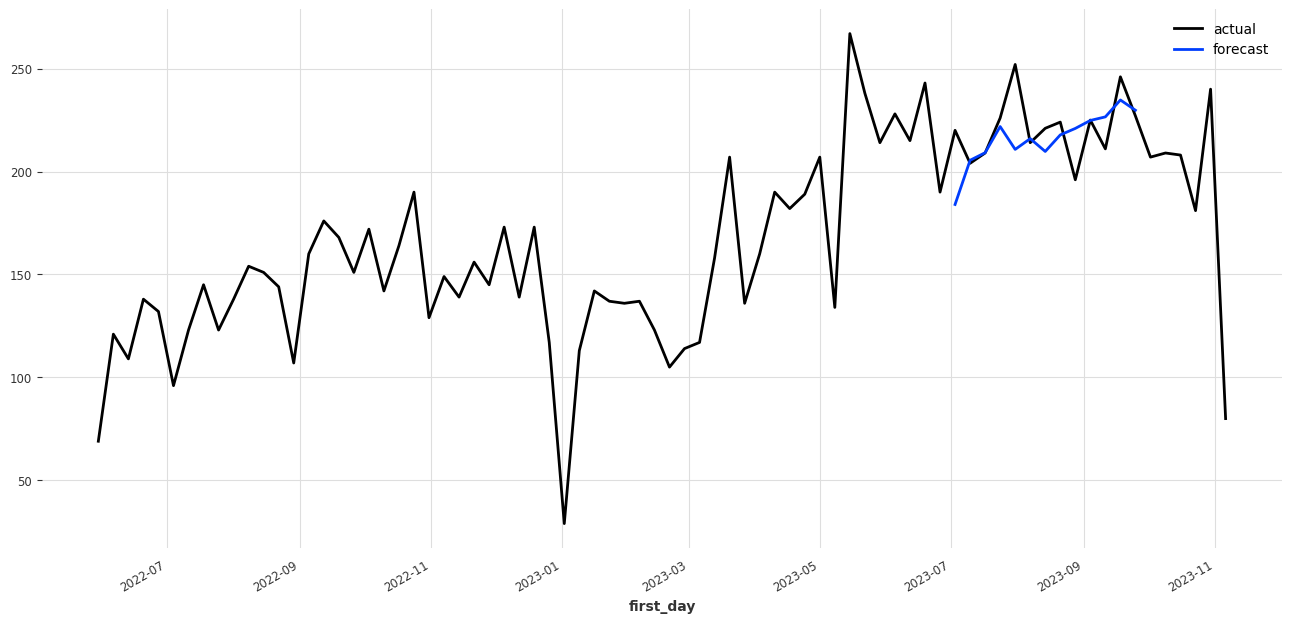

In [26]:
plt.figure(figsize=(16,7))
df_coreckt[1050].plot(label='actual')
pred_cat_1.plot(label='forecast')
plt.legend()
mape(df_test[1050], pred_cat_1)

## ******

In [ ]:
# преобразование массива временных рядов в датафрейм

def time_series_to_data_frame(t_s, *args):
    df_final = []
    b = args
    for i in t_s:
        dg = i.pd_dataframe().reset_index()
        dg[b] = i.static_covariates.reset_index(drop=True).values.flatten()
        df_final.append(dg)
    return pd.concat(df_final).reset_index(drop=True)



#=================================================================




In [27]:
df_final = []
for i in pred_cat_glob:
    dg = i.pd_dataframe().reset_index()
    dg[['№ Магазин исполнитель', 'Способ создания заказа','Способ получения заказа', 'Тип клиента']] = i.static_covariates.reset_index(drop=True).values.flatten()
    df_final.append(dg)
pd.concat(df_final).reset_index(drop=True)


component,first_day,qnt_order,№ Магазин исполнитель,Способ создания заказа,Способ получения заказа,Тип клиента
0,2023-07-03,53.133883,2.0,Онлайн,Доставка (трансп. компания),B2B
1,2023-07-10,55.894766,2.0,Онлайн,Доставка (трансп. компания),B2B
2,2023-07-17,66.342368,2.0,Онлайн,Доставка (трансп. компания),B2B
3,2023-07-24,60.121824,2.0,Онлайн,Доставка (трансп. компания),B2B
4,2023-07-31,55.658162,2.0,Онлайн,Доставка (трансп. компания),B2B
...,...,...,...,...,...,...
14165,2023-08-28,55.334811,181.0,Оффлайн,Самовывоз,Profi
14166,2023-09-04,55.909593,181.0,Оффлайн,Самовывоз,Profi
14167,2023-09-11,53.326484,181.0,Оффлайн,Самовывоз,Profi
14168,2023-09-18,57.969111,181.0,Оффлайн,Самовывоз,Profi


In [ ]:
# финальная выгрузка
output_file = "C:/Users/60126569/Мои скрипты/all_data_2.parquet"
data_a.to_parquet(output_file)